# 1. Introduction.
## 1.1. Context.
#
* According to the World Health Organization (WHO), Stroke is the second leading cause of death worldwide, responsible for approximately 11% of all deaths.
* The Strokes occurs when the blood supply to part of the brain is cut off or reduced, preventing the brain tissue from receiving oxygen and nutrients.
* A Stroke occurs when the blood supply to the brain is cut off or reduced, preventing brain tissue from receiving oxygen and nutrients, so brain cells begin to die within minutes.
* The Strokes are a medical emergency and prompt treatment is crucial. Early action can reduce brain damage and other complications.
* This data set is used to predict whether a patient is likely to have a stroke based on input parameters such as gender, age, various diseases, and smoking status. Each row of data provides relevant information about the patient.

## 1.2. Problem Statement.
#
* Improper treatment of people likely to have a stroke can have serious health consequences, including brain damage and death.

## 1.3. Objective.
#
* Understand what are the reasons that cause a stroke in people.
* Visualize the relationships between various healthy and unhealthy habits for stroke.
* Predict the probability of stroke with the best model and hyperfit parameters.

## 1.4. Available Features.

**Target**
#
1. `🏷️ stroke:` 1 if the patient had a stroke or 0 if not.

**Clinical features for predicting stroke events:**
#
1. `🔢 id:` Unique identifier.
1. `🔤 gender:` "Male", "Female" or "Other".
1. `🔢 age:`: Age of the patient.
1. `🔤 hypertension:` 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
1. `🔤 heart_disease:` 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
1. `🔤 ever_married:` "No" or "Yes".
1. `🔤 work_type:` "Children", "Govt_jov", "Never_worked", "Private" or "Self-employed".
1. `🔤 Residence_type:` "Rural" or "Urban".
1. `🔢 avg_glucose_level:` Average glucose level in blood.
1. `🔢 bmi:` Body mass index.
1. `🔤 smoking_status:` "formerly smoked", "never smoked", "smokes" or "Unknown".

## 1.5. Assumptions.
#
1. `🟢 Validated:` Advancing Age is a significant risk factor for the development of a Stroke. 
2. `🟢 Validated:` Patients with an advanced age and with a BMI have a higher risk of having Stroke.
3. `🟡 Not Proven:` Smokers with a high BMI have a higher risk of having a Stroke.
4. `🟢 Validated:` Patients with hypertension and heart disease are more likely to have a Stroke compared to those without these conditions.
5. `🟢 Validated:` Patients with elevated blood glucose levels have a higher risk of suffering a stroke compared to those with normal blood glucose levels.
6. `🟢 Validated:` Patients who live in urban areas are at higher risk of having a Stroke than those who live in rural areas.
7. `🔴 Invalid:`Married Men have an increased risk of having a Stroke than Married Women.

#2. Setup

##2.1. Libraries

In [0]:
%sh
pwd
ls

/databricks/driver
azure
conf
eventlogs
ganglia
hadoop_accessed_config.lst
logs
metastore_db
preload_class.lst
stroke-prediction-dataset.zip


In [0]:
# Import basic libraries for PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, round, when
import time
from pyspark.sql.types import DoubleType
from IPython.display import display, HTML
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Data Manipulation.
import pandas as pd
import numpy as np

# Data Visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Dimencionality Reduction.
from pyspark.ml.feature import PCA

# Imputer 
from pyspark.ml.feature import Imputer

# Data Standardization.
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer,IndexToString 
from pyspark.ml.feature import VectorAssembler,RFormula,StandardScaler
from pyspark.ml import Pipeline

# Search Hyperparameters.
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline, Model
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# PySpark Time
from pyspark.sql.functions import current_timestamp

# PySpark Warnings
import warnings
warnings.filterwarnings("ignore")

##2.2. Auxiliary Functions

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("StrokePrediction").getOrCreate()

# 1. Create a DF with the revision of the data (value count, type, null, infinity).
def df_revision(df):
    col_values_count = {col_name: df.select(col_name).distinct().count() for col_name in df.columns}
    col_dtype = {col_name: str(df.schema[col_name].dataType) for col_name in df.columns}
    col_is_obj = {col_name: 'Yes' if 'StringType' in col_dtype[col_name] or 'ObjectType' in col_dtype[col_name] else '-' for col_name in df.columns}
    
    # Check for null or empty values in each column
    col_na = {col_name: 'Yes' if df.filter((col(col_name).isNull()) | (col(col_name) == '')).count() > 0 else '-' for col_name in df.columns}
    
    col_inf = {col_name: 'Yes' if df.filter((col(col_name) == float('inf')) | (col(col_name) == float('-inf'))).count() > 0 else '-' for col_name in df.columns}

    # Modify the logic to explicitly check for DoubleType
    col_dtype = {col_name: 'DoubleType' if isinstance(df.schema[col_name].dataType, DoubleType) else col_dtype[col_name] for col_name in df.columns}

    # Create a PySpark DataFrame from the dictionary
    data = [(col_name, col_values_count[col_name], col_dtype[col_name], col_is_obj[col_name], col_na[col_name], col_inf[col_name]) for col_name in df.columns]
    columns = ['Column', 'Values_Count', 'DType', 'Is_Obj', 'NA', 'Inf']
    df_revision = spark.createDataFrame(data, columns)

    # Display HTML in Databricks notebook
    display(HTML(df_revision.toPandas().to_html(escape=False)))
    return df_revision

In [0]:
# 2. Train/Validation/Test Split
def train_val_test_split(df, target_col="target", seed=42):
    stratify_col = df[target_col] if target_col in df.columns else None
    
    train_set, test_set = df.randomSplit([0.6, 0.4], seed=seed)
    train_set, val_set = train_set.randomSplit([0.5, 0.5], seed=seed)
    
    return train_set, val_set, test_set

# 3. Remove Target (Separates the Label from the Features)
def remove_labels(df, target_name):
    X = df.drop(target_name)
    y = df.select(target_name).ravel()
    return X, y

In [0]:
# 4. Search Model
def search_model(names, models, X_train, y_train, X_val, y_val, X_test, y_test, pos_label):
    f1_Vali = []
    f1_Test = []
    fitting = []
    times = []

    for model in models:
        # ======= TRAIN ========
        start = time.time()
        fitted_model = model.fit(X_train, y_train)
        end = time.time()
        times.append(round(end - start, 3))

        # ===== VALIDATION =====
        val_predictions = fitted_model.transform(X_val)
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        f1_val = evaluator.evaluate(val_predictions)

        # ======= TEST ========
        test_predictions = fitted_model.transform(X_test)
        f1_test = evaluator.evaluate(test_predictions)

        # ======= SCORE =======
        f1_Vali.append(round(f1_val * 100, 3))
        f1_Test.append(round(f1_test * 100, 3))
        fitting.append(round((f1_val - f1_test) * 100, 3))

    df_models = spark.createDataFrame(list(zip(f1_Vali, f1_Test, fitting, times)), schema=names)
    df_models = df_models.sort(col('F1 Vali').desc(), col('F1 Test').desc(), col('Seconds').asc(), col('Fitting').desc())
    
    return df_models



In [0]:
# 5. Top Features Ranking DF
def top_features(X_train, y_train, s_X_train, s_y_train):
    # Assuming RandomForestClassifier is used for feature importance
    rank_f_model = RandomForestClassifier(maxDepth=5, numTrees=10, featureSubsetStrategy="auto", seed=42)
    fitted_model = rank_f_model.fit(X_train, y_train)
    importance_scores = fitted_model.featureImportances.toArray()

    # Assuming s_X_train and s_y_train are standardized features
    s_rank_f_model = RandomForestClassifier(maxDepth=5, numTrees=10, featureSubsetStrategy="auto", seed=42)
    s_fitted_model = s_rank_f_model.fit(s_X_train, s_y_train)
    s_importance_scores = s_fitted_model.featureImportances.toArray()

    # Convert to Pandas DataFrame for easy formatting
    df_rank_f = pd.DataFrame(list(zip(X_train.columns, importance_scores, s_X_train.columns, s_importance_scores)),
                             columns=['Features', 'Value', 'Features Standardized', 'Values S'])
    
    return df_rank_f

#3. Data Wrangling

In [0]:
%sh
pip install kaggle
:>/root/.kaggle/kaggle.json
mkdir /root/.kaggle
touch /root/.kaggle/kaggle.json
echo "{\"username\":\"hyndaviraj\",\"key\":\"d1fd1e1443b0a01d3144c148d0d8c57e\"}" >> /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d fedesoriano/stroke-prediction-dataset
unzip stroke-prediction-dataset.zip

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-c71e1a51-e3e6-4122-988d-8ee84c972457/bin/python -m pip install --upgrade pip' command.
mkdir: cannot create directory ‘/root/.kaggle’: File exists
stroke-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


##3.1. Data Load.

In [0]:
%sh
pwd
ls

/databricks/driver
azure
conf
eventlogs
ganglia
hadoop_accessed_config.lst
healthcare-dataset-stroke-data.csv
logs
metastore_db
preload_class.lst
stroke-prediction-dataset.zip


In [0]:
# Reading csv file 
df_original = spark.read.csv('file:/databricks/driver/healthcare-dataset-stroke-data.csv', inferSchema = True, header = True)

In [0]:
# Convert pandas DataFrame to PySpark DataFrame
df = df_original.alias("df")

# Dataframe for EDA (Assumptions)
df_eda = df_original.alias("df_eda")

# Dataframe for Modeling
df_m = df_original.alias("df_m")

##3.2. Data Descriptive.

###3.2.1. Data View.

In [0]:
display(HTML(df.toPandas().head(5).to_html(escape=False)))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [0]:
# Number of rows in a dataset
df.count()

Out[36]: 5110

In [0]:
# Displaying the dataframe
display(df)

DataFrame[id: int, gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: string, smoking_status: string, stroke: int]

###3.2.2. Statistics of Categorical and Numerical Data.

In [0]:
# Use the withColumn method to add or update a column
# Here we are type casting column 'bmi' to Double
df = df.withColumn("bmi", col("bmi").cast("double"))


In [0]:
# Display summary statistics for all columns, including non-numeric columns
summary_stats = df.summary()

# Define a list of non-numeric columns
non_numeric_cols = [col_name for col_name, data_type in df.dtypes if data_type not in ('int', 'double')]

# Fill missing values in numeric columns with '-'
for col_name in summary_stats.columns:
    if col_name != 'summary' and col_name not in non_numeric_cols:
        summary_stats = summary_stats.na.fill('-', subset=[col_name])

# Fill missing values in non-numeric columns with '-'
for col_name in non_numeric_cols:
    summary_stats = summary_stats.withColumn(col_name, when(col(col_name).isNotNull(), col(col_name)).otherwise('-'))


# Round all numeric columns to 1 decimal place
for col_name in summary_stats.columns:
    if col_name != 'summary' and col_name not in non_numeric_cols:
        summary_stats = summary_stats.withColumn(col_name, col(col_name).cast('double'))



# Display the DataFrame
display(HTML(summary_stats.toPandas().to_html(escape=False)))

,summary,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
1,mean,36517.829354,-,43.226614,0.097456,0.054012,-,-,-,106.147677,28.893237,-,0.048728
2,stddev,21161.721625,-,22.612647,0.296607,0.226063,-,-,-,45.283560,7.854067,-,0.215320
3,min,67.000000,Female,0.080000,0.000000,0.000000,No,Govt_job,Rural,55.120000,10.300000,Unknown,0.000000
4,25%,17739.000000,-,25.000000,0.000000,0.000000,-,-,-,77.230000,23.500000,-,0.000000
5,50%,36909.000000,-,45.000000,0.000000,0.000000,-,-,-,91.850000,28.100000,-,0.000000
6,75%,54643.000000,-,61.000000,0.000000,0.000000,-,-,-,114.090000,33.100000,-,0.000000
7,max,72940.000000,Other,82.000000,1.000000,1.000000,Yes,children,Urban,271.740000,97.600000,smokes,1.000000


**Observations:**

🔎 In all the characteristics there are 5,110 copies except the characteristic "bmi".

🔎 The scales in the numerical characteristics are very different.

🔎 The dispersion of the data in characteristics such as "age" and "avg_glucose_level" is high.

In [0]:
# Finding duplicates in data
# count the occurrences of each row
duplicates = df.groupBy(df.columns)\
    .agg(count("*").alias("count"))\
    .where(col("count") > 1)

# show the duplicate rows
display(HTML(duplicates.toPandas().to_html(escape=False)))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,count


**Observations:**

🔎 There are no duplicates in the above dataset

In [0]:
# Check for missing values and sum them up
missing_values = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Display the result
display(HTML(missing_values.toPandas().to_html(escape=False)))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,201,0,0


**Observations:**

🔎 There are NA values only in "bmi" column

###3.2.3. Data Revision.

In [0]:
# The characteristics of the DF features are reviewed (Auxiliary Function is used).
df_revision(df)

,Column,Values_Count,DType,Is_Obj,NA,Inf
0,id,5110,IntegerType(),-,-,-
1,gender,3,StringType(),Yes,-,-
2,age,104,DoubleType,-,-,-
3,hypertension,2,IntegerType(),-,-,-
4,heart_disease,2,IntegerType(),-,-,-
5,ever_married,2,StringType(),Yes,-,-
6,work_type,5,StringType(),Yes,-,-
7,Residence_type,2,StringType(),Yes,-,-
8,avg_glucose_level,3979,DoubleType,-,-,-
9,bmi,419,DoubleType,-,Yes,-


Out[42]: DataFrame[Column: string, Values_Count: bigint, DType: string, Is_Obj: string, NA: string, Inf: string]

**Observations:** 

🔎 The "id" feature does not add value in the analysis because it is different for each instance.

🔎 We have categorical features that will have to be encoded for analysis.

🔎 The feature "bmi" has null values.

🔎 The data does not contain infinite values.

In [0]:
# Gets the names of the categorical features.
features_cat = [col_name for col_name, col_type in df.dtypes if col_type == 'string']

# The features with categories of a size smaller than 3% of the data are obtained.
for feature_cat in features_cat:
    count = df.groupBy(feature_cat).count().withColumn("percentage", col("count") / df.count() * 100)
    
    small_categories = count.filter(col("percentage") < 3)
    
    if small_categories.count() > 0:
        print(f"\nSize in % of Categories in {feature_cat} less than 1%:\n")
        display(HTML(small_categories.toPandas().to_html(escape=False)))
    


Size in % of Categories in gender less than 1%:



,gender,count,percentage
0,Other,1,0.019569



Size in % of Categories in work_type less than 1%:



,work_type,count,percentage
0,Never_worked,22,0.430528


**Observations:** 

🔎 Features with very small categories could generate noise to the classification model such as,

  🔎 The "Gender" feature have the "Other" category which is only 0.02% of the data that is equal to only 1 patient.

  🔎 The "work_type" feature has the category "Never_worked" category, which is only 0.44% of the data, that is equivalent to 22 patients.

### 3.2.5. Review of Target Values.

In [0]:
# Dataframe with count of Target values
stroke_count = df.groupBy('stroke').count().withColumnRenamed('count', '# Count')

# Calculate the percentage
total_rows = df.count()
stroke_percent = stroke_count.withColumn('% Percentage', (col('# Count') / total_rows) * 100)

# Round the percentage column to 2 decimal places
stroke_percent = stroke_percent.withColumn('% Percentage', round(col('% Percentage'), 2))

# Display the result
display(HTML(stroke_percent.toPandas().to_html(escape=False)))

,stroke,# Count,% Percentage
0,1,249,4.87
1,0,4861,95.13


**Observations:** 

🔎 We have data with a high level of imbalance.

🔎 95% of patients have not had a stroke.

🔎 Only 5% of patients in the entire dataset have had a stroke.

##3.3. Preprocessing for Analysis.

###3.3.1. Remove Unnecessary Categories

In [0]:
# Drop the 'id' column
df = df.drop('id')

**Observations:** 

🔎 We removed the "id" feature because it generates noise in the analysis.

###3.3.2. Missing Values.

In [0]:
# The NA in the 'bmi' feature are reviewed
bmi_na = df.filter(col('bmi').isNull()).count()

# Get the Standard Deviation of the feature 'bmi'
bmi_std = df.agg({'bmi': 'stddev'}).collect()[0]['stddev(bmi)']

# Get the Median of the feature 'bmi'
bmi_median = df.approxQuantile('bmi', [0.5], 0.001)[0]

# We fill NA of the feature 'bmi' with the median of its values
df = df.withColumn('bmi', when(col('bmi').isNull(), bmi_median).otherwise(col('bmi')))

# Display the results
print("\n'bmi' NA count: ", bmi_na)
print("'bmi' Std : ", bmi_std)
print("'bmi' Median : ", bmi_median)
print("'bmi' NA count after fill: ", df.filter(col('bmi').isNull()).count())


'bmi' NA count:  201
'bmi' Std :  7.85406672968016
'bmi' Median :  28.0
'bmi' NA count after fill:  0


**Observations:** 

🔎 The Median of the 'bmi' data is used to fill in the NA values.

🔎 The mean is not used to prevent outliers from over-altering the data.

🔎 The standard deviation in the data is high, so it is decided to use the Median.

###3.3.2. Encode Features.

In [0]:
# DF for Encode
df_encode = df

# Categorical columns to be one-hot encoded
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Indexing and encoding each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]

# Assemble indexed and encoded columns into a single vector
assembler = VectorAssembler(inputCols=[col + "_encoded" for col in categorical_cols],
                            outputCol="features")

# Create a pipeline with the stages
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform the data using the pipeline
df_transformed = pipeline.fit(df_encode).transform(df_encode)

# Manually create the desired output columns
output_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke'] + \
                 [col + "_encoded" for col in categorical_cols]

df_encoded = df_transformed.select(*output_columns)

# UDF to convert vectors to lists
vector_to_list_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Apply the UDF to the specified columns
df_encoded = (
    df_encoded
    .withColumn("gender_encoded", vector_to_list_udf("gender_encoded"))
    .withColumn("work_type_encoded", vector_to_list_udf("work_type_encoded"))
    .withColumn("smoking_status_encoded", vector_to_list_udf("smoking_status_encoded"))
    .withColumn("ever_married_encoded", vector_to_list_udf("ever_married_encoded"))
    .withColumn("Residence_type_encoded", vector_to_list_udf("Residence_type_encoded"))
)

df_encoded = (
    df_encoded
    .withColumn("ever_married_yes", col("ever_married_encoded")[0])
    .withColumn("Residence_type_urban", col("Residence_type_encoded")[0])
    .withColumn("gender_male", col("gender_encoded")[0])
    .withColumn("gender_female", col("gender_encoded")[1])
    .withColumn("work_type_Never_worked", col("work_type_encoded")[0])
    .withColumn("work_type_Private", col("work_type_encoded")[1])
    .withColumn("work_type_Self-employed", col("work_type_encoded")[2])
    .withColumn("work_type_children", col("work_type_encoded")[3])
    .withColumn("smoking_status_formerly_smoked", col("smoking_status_encoded")[0])
    .withColumn("smoking_status_never_smoked", col("smoking_status_encoded")[1])
    .withColumn("smoking_status_smokes", col("smoking_status_encoded")[2])
    .drop("gender_encoded", "work_type_encoded", "smoking_status_encoded", "ever_married_encoded", "Residence_type_encoded")
)

# Move the 'stroke' column to the end
df_encoded = df_encoded.select(
    *[col(c) for c in df_encoded.columns if c != 'stroke'],
    col('stroke')
).drop("gender_female")

# Cast double columns to integer
double_columns = ["ever_married_yes", "Residence_type_urban", "gender_male", "work_type_Never_worked", "work_type_Private", "work_type_Self-employed", "work_type_children", "smoking_status_formerly_smoked", "smoking_status_never_smoked", "smoking_status_smokes"]
for col_name in double_columns:
    df_encoded = df_encoded.withColumn(col_name, col(col_name).cast("int"))

display(HTML(df_encoded.toPandas().head(5).to_html(escape=False)))

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_yes,Residence_type_urban,gender_male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes,stroke
0,67.0,0,1,228.69,36.6,1,1,0,1,0,0,0,0,0,1,1
1,61.0,0,0,202.21,28.0,1,0,1,0,1,0,0,1,0,0,1
2,80.0,0,1,105.92,32.5,1,0,0,1,0,0,0,1,0,0,1
3,49.0,0,0,171.23,34.4,1,1,1,1,0,0,0,0,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,1,0,0,1


**Observations:**

🔎 Object type features are encoded in order to obtain correlations with numerical features.

🔎 We have prepared the data for a machine learning model by encoding categorical variables, creating binary columns for better interpretability, and ensuring the data is in a format suitable for training a predictive model. 

🔎 The DF 'df_encoded' is used in the "Distribution of Features According to Target" and "Matrix Correlation" graph.

###3.3.3. Dimensionality Reduction (PCA)

In [0]:
# Drop the 'stroke' column from the features
features_encode = df_encoded.drop('stroke')

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features_encode.columns, outputCol="features")

# Apply PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pipeline = Pipeline(stages=[assembler, pca])
model = pipeline.fit(df_encoded)
df_pca = model.transform(df_encoded).select("pca_features", "stroke")
df_pca = (
    df_pca
    .withColumn("pca_features", vector_to_list_udf("pca_features"))
)
df_pca = (
    df_pca
    .withColumn("feature_1", col("pca_features")[0])
    .withColumn("feature_2", col("pca_features")[1])
    .drop("pca_features")
)

# Move the 'stroke' column to the end
df_pca = df_pca.select(
    *[col(c) for c in df_pca.columns if c != 'stroke'],
    col('stroke')
).drop("gender_female")

# Show the result
display(HTML(df_pca.toPandas().head(10).to_html(escape=False)))

,feature_1,feature_2,stroke
0,-237.341163,34.036368,1
1,-209.986896,31.341349,1
2,-117.960935,65.543074,1
3,-177.754696,25.113517,1
4,-184.883699,52.960056,1
5,-197.292721,53.578191,1
6,-81.489250,64.700263,1
7,-104.564370,55.466973,1
8,-85.183655,49.084774,1
9,-70.618800,70.060074,1


**Observations:**

🔎 The extraction of the features is carried out to be able to visualize the distribution of the data.

🔎 See how we performed dimensionality reduction using Principal Component Analysis (PCA), Pipeline and transformation,on the features obtained from the previously prepared DataFrame (df_encoded) was preserved for each characteristic of the target data set with respect to the original.

🔎 The DF 'df_pca' is used in the "Distribution of Features According to Target" graph.

---
# 4. Analysis.

## 4.1. Assumptions Answer.

In [0]:
palette = sns.color_palette("Set2") 

In [0]:
# Drop the 'id' column
df_eda = df_eda.drop('id')

### 4.1.1. Advancing Age is a significant risk factor for the development of a Stroke.

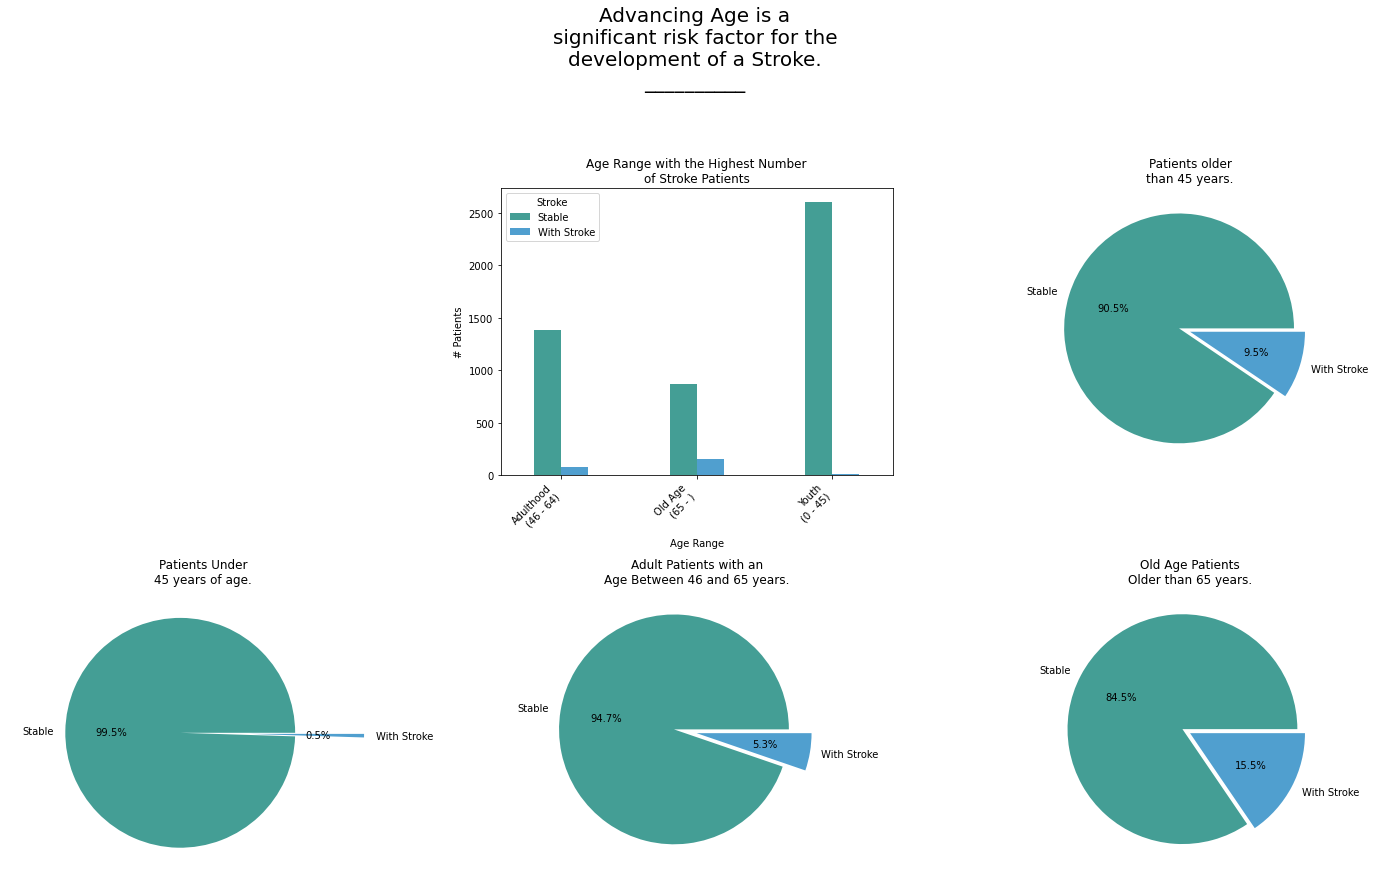

In [0]:
df_eda = df_eda.withColumn(
    'age_range',
    when((col('age') >= 0) & (col('age') <= 45), 'Youth\n(0 - 45)')
    .when((col('age') > 45) & (col('age') <= 64), 'Adulthood\n(46 - 64)')
    .when(col('age') >= 65, 'Old Age\n(65 - )')
)

df_eda = df_eda.withColumn(
    'old_age',
    when(col('age') <= 45, 'Youth')
    .otherwise('Adulthood & Old Age')
)

# Calculate percentages
adul_old_total = df_eda.filter(col('old_age') == 'Adulthood & Old Age').count()
patients_adul_old = df_eda.filter((col('old_age') == 'Adulthood & Old Age') & (col('stroke') == 0)).count() / adul_old_total * 100
patients_adul_old_stroke = df_eda.filter((col('old_age') == 'Adulthood & Old Age') & (col('stroke') == 1)).count() / adul_old_total * 100

youth_total = df_eda.filter(col('age_range') == 'Youth\n(0 - 45)').count()
patients_youth = df_eda.filter((col('age_range') == 'Youth\n(0 - 45)') & (col('stroke') == 0)).count() / youth_total * 100
patients_youth_stroke = df_eda.filter((col('age_range') == 'Youth\n(0 - 45)') & (col('stroke') == 1)).count() / youth_total * 100

adul_total = df_eda.filter(col('age_range') == 'Adulthood\n(46 - 64)').count()
patients_adul = df_eda.filter((col('age_range') == 'Adulthood\n(46 - 64)') & (col('stroke') == 0)).count() / adul_total * 100
patients_adul_stroke = df_eda.filter((col('age_range') == 'Adulthood\n(46 - 64)') & (col('stroke') == 1)).count() / adul_total * 100

old_total = df_eda.filter(col('age_range') == 'Old Age\n(65 - )').count()
patients_old = df_eda.filter((col('age_range') == 'Old Age\n(65 - )') & (col('stroke') == 0)).count() / old_total * 100
patients_old_stroke = df_eda.filter((col('age_range') == 'Old Age\n(65 - )') & (col('stroke') == 1)).count() / old_total * 100

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Advancing Age is a\nsignificant risk factor for the\ndevelopment of a Stroke.\n__________', fontsize=20, y=1.02)  # Adjust y to move the title higher

axs[0, 0].axis('off')  
# Plot Age Range
df_age_range = df_eda.groupBy('age_range', 'stroke').count().toPandas()

# Pivot the DataFrame to get separate columns for stroke 0 and 1
df_age_range_pivot = df_age_range.pivot(index='age_range', columns='stroke', values='count')

# Plot the grouped bar chart
df_age_range_pivot.plot(kind='bar', ax=axs[0, 1], color=['#449E95', '#509FCF'], width=0.4)

axs[0, 1].set_title("Age Range with the Highest Number\nof Stroke Patients")
axs[0, 1].legend(title='Stroke', labels=['Stable', 'With Stroke'])
axs[0, 1].set_xlabel('Age Range')
axs[0, 1].set_ylabel('# Patients')

# Adjust the x-axis ticks and labels for better visibility
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


# Plot Adul Old
axs[0, 2].pie([patients_adul_old, patients_adul_old_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors=['#449E95', '#509FCF'])
axs[0, 2].set_title("Patients older\nthan 45 years.")

# Plot Youth
axs[1, 0].pie([patients_youth, patients_youth_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.4], colors=['#449E95', '#509FCF'])
axs[1, 0].set_title("Patients Under\n45 years of age.")

# Plot Adul
axs[1, 1].pie([patients_adul, patients_adul_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors=['#449E95', '#509FCF'])
axs[1, 1].set_title("Adult Patients with an\nAge Between 46 and 65 years.")

# Plot Old
axs[1, 2].pie([patients_old, patients_old_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.075, 0], colors=['#449E95', '#509FCF'])
axs[1, 2].set_title("Old Age Patients\nOlder than 65 years.")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to leave space for suptitle
plt.show()



**Observations:**

🔎 There is a positive trend of patients who have had a Stroke according to their age.

🔎 9.5% patients older than 45 have suffered a Stroke.

🔎 Patients over 65 are the population of age with more stroke cases of 15.5%.

🔎 5.3% of patients between 46 and 65 years have had a Stroke.

🔎 Only 0.5% of patients under 45 have had a Stroke.

**Conclusions:** 

📌 The assumption was fulfilled, the elderly (over 45 years) is a higher risk factor for a Stroke.

📌 Patients over 65 should be more careful not to suffer a stroke.

### 4.1.2. Patients with an Advanced Age and with a BMI have a higher risk of having Stroke.

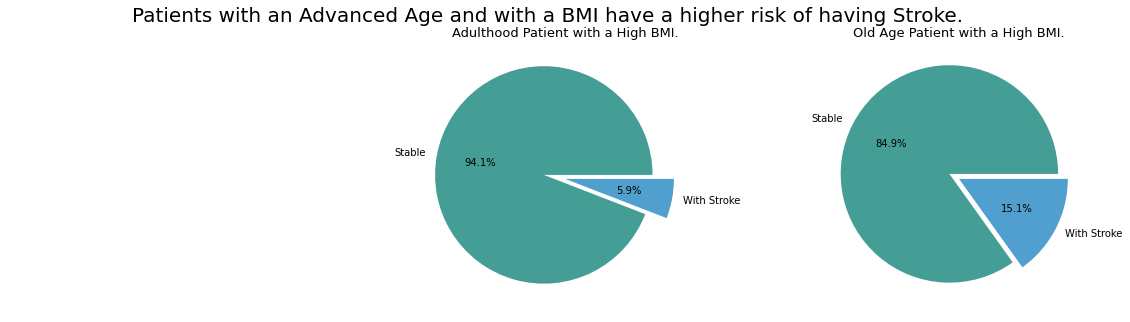

In [0]:
# DF of Patients categorized by their high BMI
df_eda = df_eda.withColumn('high_BMI', F.when((F.col('bmi') >= 0) & (F.col('bmi') <= 18.5), 'Below Average')
                           .when((F.col('bmi') > 18.5) & (F.col('bmi') <= 24.9), 'Normal')
                           .otherwise('High BMI'))

# Adulthood
adulthood_df = df_eda.filter((F.col('age_range') == 'Adulthood\n(46 - 64)') & (F.col('high_BMI') == 'High BMI'))
adul_h_AgeBMI_total = adulthood_df.count()
adul_h_AgeBMI = (adulthood_df.filter(F.col('stroke') == 0).count() / adul_h_AgeBMI_total) * 100
adul_h_AgeBMI_stroke = (adulthood_df.filter(F.col('stroke') == 1).count() / adul_h_AgeBMI_total) * 100

# Old Age
old_age_df = df_eda.filter((F.col('age_range') == 'Old Age\n(65 - )') & (F.col('high_BMI') == 'High BMI'))
old_h_AgeBMI_total = old_age_df.count()
old_h_AgeBMI = (old_age_df.filter(F.col('stroke') == 0).count() / old_h_AgeBMI_total) * 100
old_h_AgeBMI_stroke = (old_age_df.filter(F.col('stroke') == 1).count() / old_h_AgeBMI_total) * 100

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Patients with an Advanced Age and with a BMI have a higher risk of having Stroke.', fontsize=20)

# Plot Adulthood
axs[1].pie([adul_h_AgeBMI, adul_h_AgeBMI_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors=['#449E95', '#509FCF'])
axs[1].set_title('Adulthood Patient with a High BMI.', fontsize=13)

# Plot Old Age
axs[2].pie([old_h_AgeBMI, old_h_AgeBMI_stroke], labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors=['#449E95', '#509FCF'])
axs[2].set_title('Old Age Patient with a High BMI.', fontsize=13)

# Remove axis for the plot title
axs[0].set_axis_off()
plt.show()


**Observations:**

🔎 5.9% of patients at an age between 46 and 65 have had a Stroke.

🔎 Patients over 65 have had 15.1% of stroke cases.

🔎 Most of the "adulthood" and "Old Age" patients have a high BMI (complement with graph at point 4.1.1).

**Conclusions:**

📌 Assumption was fulfilled, age and BMI is a risk factor to have a stroke.

📌 Patients over 46 should improve their BMI since most of those who at that age have a stroke have a high BMI.

### 4.1.3. Smokers with a high BMI have a higher risk of having a Stroke.

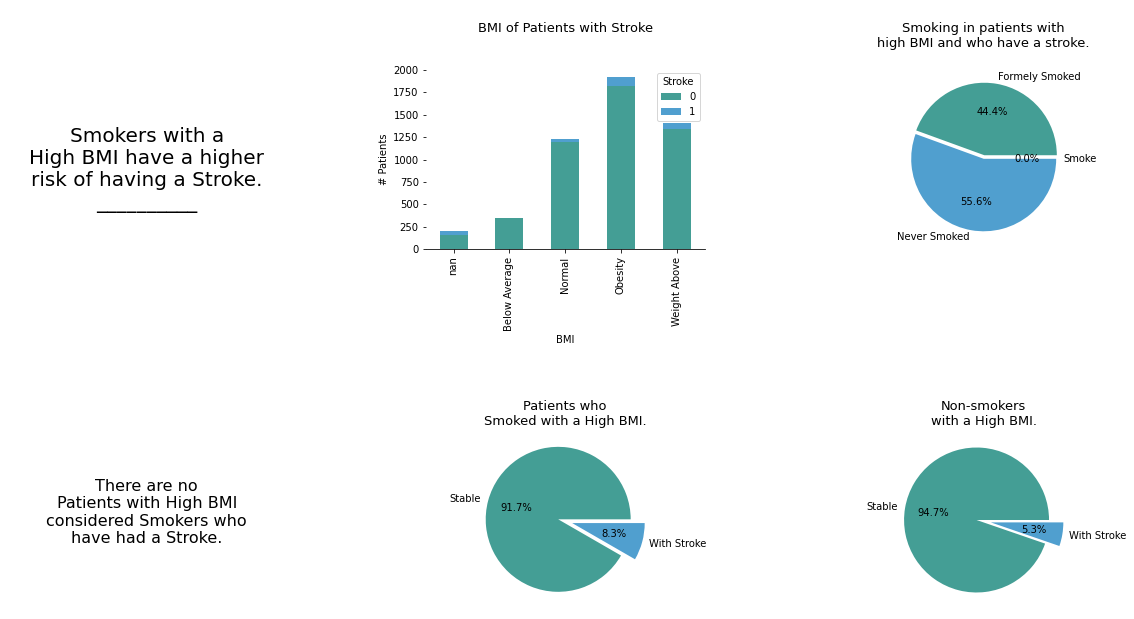

In [0]:
# Categorize BMI
df_eda = df_eda.withColumn('bmi_cat', F.when((F.col('bmi') <= 18.5), 'Below Average')
                                      .when((F.col('bmi') > 18.5) & (F.col('bmi') <= 24.9), 'Normal')
                                      .when((F.col('bmi') > 24.9) & (F.col('bmi') <= 29.9), 'Weight Above')
                                      .when(F.col('bmi') > 29.9, 'Obesity'))

# Count smokers with high BMI
smokes_stroke_len = df_eda.filter((F.col('smoking_status') == 'smoke') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 1)).count()
f_smokes_stroke_len = df_eda.filter((F.col('smoking_status') == 'formerly smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 1)).count()
no_smokes_stroke_len = df_eda.filter((F.col('smoking_status') == 'never smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 1)).count()

# Formerly Smokes
f_smokes = df_eda.filter((F.col('smoking_status') == 'formerly smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 0)).count()
f_smokes_stroke = df_eda.filter((F.col('smoking_status') == 'formerly smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 1)).count()
f_smokes_total = df_eda.filter((F.col('smoking_status') == 'formerly smoked') & (F.col('high_BMI') == 'High BMI')).count()
f_smokes = (f_smokes / f_smokes_total) * 100
f_smokes_stroke = (f_smokes_stroke / f_smokes_total) * 100
f_smoke_highBMI = (f_smokes, f_smokes_stroke)

# No Smokes
no_smokes = df_eda.filter((F.col('smoking_status') == 'never smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 0)).count()
no_smokes_stroke = df_eda.filter((F.col('smoking_status') == 'never smoked') & (F.col('high_BMI') == 'High BMI') & (F.col('stroke') == 1)).count()
no_smokes_total = df_eda.filter((F.col('smoking_status') == 'never smoked') & (F.col('high_BMI') == 'High BMI')).count()
no_smoke = (no_smokes / no_smokes_total) * 100
no_smokes_stroke = (no_smokes_stroke / no_smokes_total) * 100
no_smoke_highBMI = (no_smoke, no_smokes_stroke)

# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=0.5, hspace=1)

# Plot Title High BMI
ax0 = axs[0, 0]
ax0.text(0.5, 0.5, '\nSmokers with a\nHigh BMI have a higher\nrisk of having a Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

# Plot
ax1 = axs[0, 1]
df_eda_grouped = df_eda.groupBy('bmi_cat', 'stroke').count().orderBy('bmi_cat', 'stroke').toPandas()
df_eda_grouped.pivot(index='bmi_cat', columns='stroke', values='count').plot(kind='bar', stacked=True, ax=ax1, color=['#449E95', '#509FCF'])
ax1.set_title(f"\nBMI of Patients with Stroke\n\n", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('BMI')
ax1.set_ylabel('# Patients')

# Plot Smoke Status Stroke
ax2 = axs[0, 2]
ax2.pie([smokes_stroke_len, f_smokes_stroke_len, no_smokes_stroke_len], autopct='%1.1f%%', explode=[0, 0.05, 0],
        labels=['Smoke', 'Formely Smoked', 'Never Smoked'], colors=['#D37EE3', '#449E95', '#509FCF'])
ax2.set_title("\nSmoking in patients with\nhigh BMI and who have a stroke.\n", fontsize=13)

# Plot Title Smoke
ax3 = axs[1, 0]
ax3.text(0.5, 0.5, 'There are no\nPatients with High BMI\nconsidered Smokers who\nhave had a Stroke.\n',
         fontsize=16, horizontalalignment='center', verticalalignment='center')
ax3.axis('off')

# Plot Formerly Smokes
ax4 = axs[1, 1]
ax4.pie(f_smoke_highBMI, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax4.set_title("Patients who\nSmoked with a High BMI.", fontsize=13)

# Plot No Smokes
ax5 = axs[1, 2]
ax5.pie(no_smoke_highBMI, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax5.set_title("Non-smokers\nwith a High BMI.", fontsize=13)

# Show the plot
plt.show()


**Observations:**

🔎 There is a positive trend of patients who have had a Stroke as they have a high BMI.

🔎 There are no data from patients who smoke, have a high BMI and have a Stroke.

🔎 The patients who smoked and who have a high BMI, 8.3% have had a Stroke.

🔎 The patients who have never smoked but have a high BMI 5.3% have had a Stroke.

🔎 The percentage of patients with Stroke with a high BMI between those who smoked and those who did not smoke is very similar.

**Conclusions:**

📌 The assumption has not been possible to verify, there are no data from patients who smoke with a high BMI and have a stroke.

📌 It is recommended that these patients decrease their BMI level since it is a strong factor to suffer from a Stroke.

### 4.1.4. Patients with Hypertension and Heart Disease are more likely to have a Stroke compared to those without these conditions.

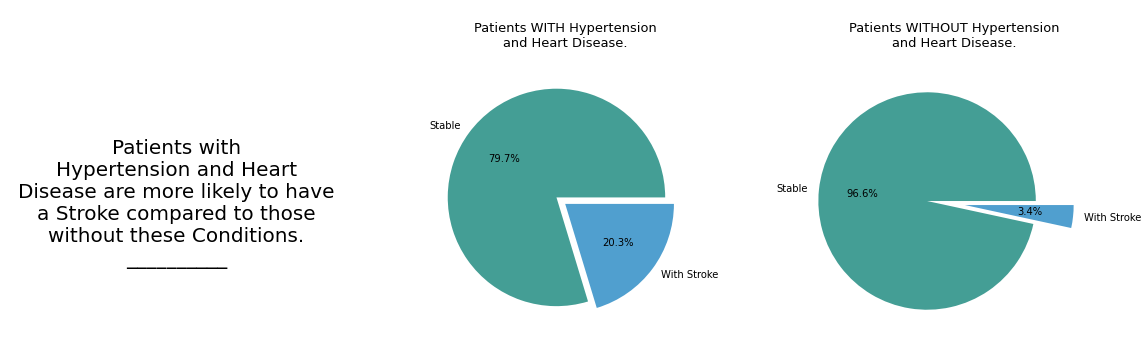

In [0]:
# With Hypertension and Heart Disease
with_hh = df_eda.filter((F.col('hypertension') == 1) & (F.col('heart_disease') == 1) & (F.col('stroke') == 0)).count()
with_hh_stroke = df_eda.filter((F.col('hypertension') == 1) & (F.col('heart_disease') == 1) & (F.col('stroke') == 1)).count()
with_hh_total = df_eda.filter((F.col('hypertension') == 1) & (F.col('heart_disease') == 1)).count()
with_hh = (with_hh / with_hh_total) * 100
with_hh_stroke = (with_hh_stroke / with_hh_total) * 100
patients_with_hh = [with_hh, with_hh_stroke]

# Without Hypertension and Heart Disease
without_hh = df_eda.filter((F.col('hypertension') == 0) & (F.col('heart_disease') == 0) & (F.col('stroke') == 0)).count()
without_hh_stroke = df_eda.filter((F.col('hypertension') == 0) & (F.col('heart_disease') == 0) & (F.col('stroke') == 1)).count()
without_hh_total = df_eda.filter((F.col('hypertension') == 0) & (F.col('heart_disease') == 0)).count()
without_hh = (without_hh / without_hh_total) * 100
without_hh_stroke = (without_hh_stroke / without_hh_total) * 100
patients_without_hh = [without_hh, without_hh_stroke]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.15)

# Plot Title
ax0 = axs[0]
ax0.text(0.5, 0.5, 'Patients with\nHypertension and Heart\nDisease are more likely to have\na Stroke compared to those\nwithout these Conditions.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

# Plot With
ax1 = axs[1]
ax1.pie(patients_with_hh, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors=['#449E95', '#509FCF'])
ax1.set_title("\nPatients WITH Hypertension\nand Heart Disease.\n", fontsize=13)

# Plot Without
ax2 = axs[2]
ax2.pie(patients_without_hh, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.25, 0.1], colors=['#449E95', '#509FCF'])
ax2.set_title("\nPatients WITHOUT Hypertension\nand Heart Disease.\n", fontsize=13)

# Show the plot
plt.show()


**Observations:**

🔎 20.3% of patients with Hypertension and Heart Diseasew have had a Stroke.

🔎 The patients without hypertension and Heart Disease 3.4% have not had a Stroke.

🔎 Patients who have these conditions have almost 7 times more likely to have a Stroke.

**Conclusions:**

📌 The assumption was fulfilled, having both conditions increases the probability of having a Stroke.

📌 It is recommended that keeping patients with both conditions stable because it significantly increases the probability of having a Stroke.

### 4.1.5. Patients with elevated Blood Glucose levels have a higher risk of suffering a Stroke compared to those with Normal Glucose Levels.

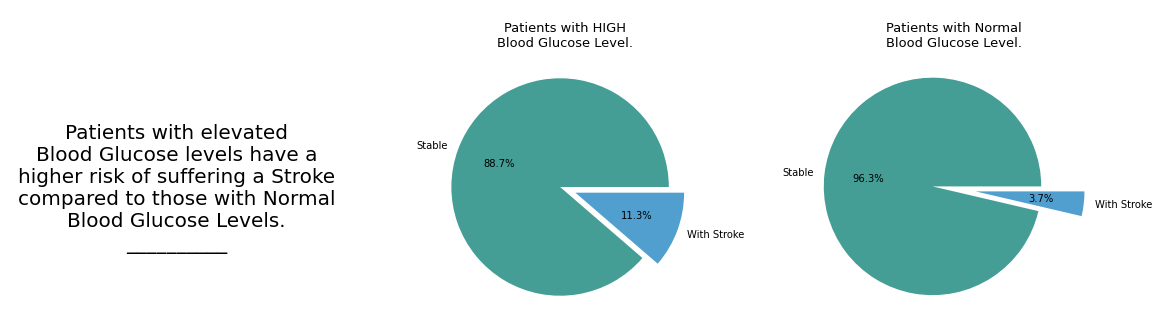

In [0]:
# Create a new column for average glucose level range
df_eda = df_eda.withColumn('avg_gluc_lvl_range', F.when((F.col('avg_glucose_level') <= 70), 'Low Level')
                                               .when((F.col('avg_glucose_level') <= 140), 'Normal Level')
                                               .otherwise('High Level'))

# High
high = df_eda.filter((F.col('avg_gluc_lvl_range') == 'High Level') & (F.col('stroke') == 0)).count()
high_stroke = df_eda.filter((F.col('avg_gluc_lvl_range') == 'High Level') & (F.col('stroke') == 1)).count()
high_total = df_eda.filter(F.col('avg_gluc_lvl_range') == 'High Level').count()
high = (high / high_total) * 100
high_stroke = (high_stroke / high_total) * 100
patients_high = [high, high_stroke]

# Normal
normal = df_eda.filter((F.col('avg_gluc_lvl_range') == 'Normal Level') & (F.col('stroke') == 0)).count()
normal_stroke = df_eda.filter((F.col('avg_gluc_lvl_range') == 'Normal Level') & (F.col('stroke') == 1)).count()
normal_total = df_eda.filter(F.col('avg_gluc_lvl_range') == 'Normal Level').count()
normal = (normal / normal_total) * 100
normal_stroke = (normal_stroke / normal_total) * 100
patients_normal = [normal, normal_stroke]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.15)

# Plot Title
ax0 = axs[0]
ax0.text(0.5, 0.5, 'Patients with elevated\nBlood Glucose levels have a\nhigher risk of suffering a Stroke\ncompared to those with Normal\nBlood Glucose Levels.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

# Plot High
ax1 = axs[1]
ax1.pie(patients_high, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.05, 0.1], colors=['#449E95', '#509FCF'])
ax1.set_title("\nPatients with HIGH\nBlood Glucose Level.", fontsize=13)

# Plot Normal
ax2 = axs[2]
ax2.pie(patients_normal, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.2], colors=['#449E95', '#509FCF'])
ax2.set_title("\nPatients with Normal\nBlood Glucose Level.", fontsize=13)

# Show the plot
plt.show()


**Observations:**

🔎 11.3% of patients with high glucose level have had a Stroke.

🔎 Of the patients who have a normal level of glucose only 3.7% have had a Stroke.

🔎 Patients with a high glucose level have 3 times more likely to have a Stroke.

**Conclusions:**

📌 The assumption was fulfilled, patients with a high level of glucose are more likely to have a Stroke

📌 It is recommended that patients with high glucose level carry a better diet and physical activity to reduce the probability of having a Stroke.

### 4.1.6. Patients who live in Urban Areas are at Higher risk of having a Stroke than those who live in Rural Areas.

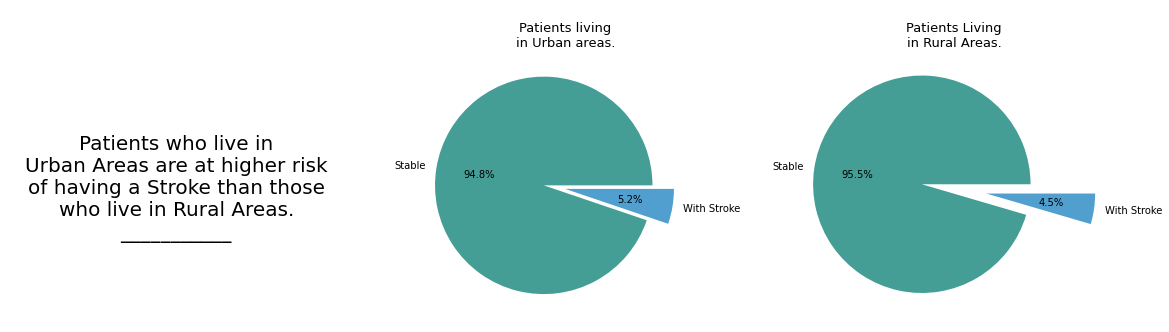

In [0]:
# Urban
urban = df_eda.filter((F.col('Residence_type') == 'Urban') & (F.col('stroke') == 0)).count()
urban_stroke = df_eda.filter((F.col('Residence_type') == 'Urban') & (F.col('stroke') == 1)).count()
urban_total = df_eda.filter(F.col('Residence_type') == 'Urban').count()
urban = (urban / urban_total) * 100
urban_stroke = (urban_stroke / urban_total) * 100
patients_urban = [urban, urban_stroke]

# Rural
rural = df_eda.filter((F.col('Residence_type') == 'Rural') & (F.col('stroke') == 0)).count()
rural_stroke = df_eda.filter((F.col('Residence_type') == 'Rural') & (F.col('stroke') == 1)).count()
rural_total = df_eda.filter(F.col('Residence_type') == 'Rural').count()
rural = (rural / rural_total) * 100
rural_stroke = (rural_stroke / rural_total) * 100
patients_rural = [rural, rural_stroke]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.15)

# Plot Title
ax0 = axs[0]
ax0.text(0.5, 0.5, 'Patients who live in\nUrban Areas are at higher risk\nof having a Stroke than those\nwho live in Rural Areas.\n___________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

# Plot Urban
ax1 = axs[1]
ax1.pie(patients_urban, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors=['#449E95', '#509FCF'])
ax1.set_title("\nPatients living\nin Urban areas.", fontsize=13)

# Plot Rural
ax2 = axs[2]
ax2.pie(patients_rural, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.3, 0.3], colors=['#449E95', '#509FCF'])
ax2.set_title("\nPatients Living\nin Rural Areas.", fontsize=13)

# Show the plot
plt.show()


**Observations:**

🔎 Of the people living in urban areas 5.2% have had a Stroke.

🔎 95.5% of people living in rural areas have not had a Stroke.

**Conclusions:**

📌 Assumption was fulfilled, patients living in urban areas are more likely to have a Stroke.

📌 Patients living in urban areas are recommended to reduce their stress levels in the possible.

### 4.1.7. Married Men have an increased risk of having a Stroke than Married Women.

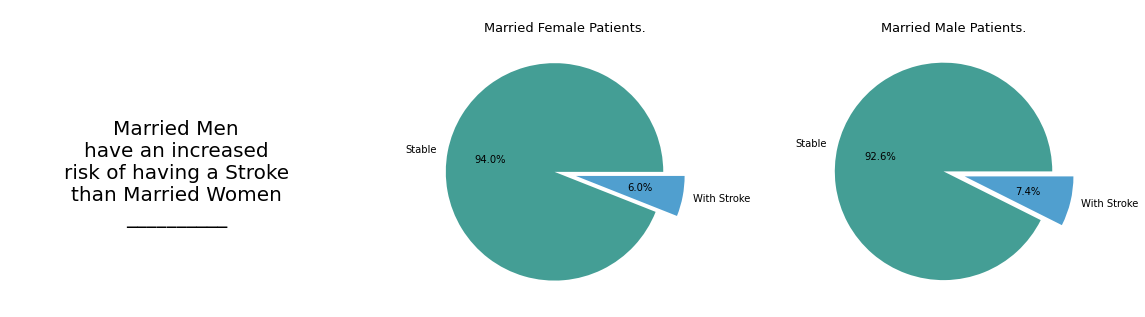

In [0]:
# Female
female = df_eda.filter((F.col('gender') == 'Female') & (F.col('ever_married') == 'Yes') & (F.col('stroke') == 0)).count()
female_stroke = df_eda.filter((F.col('gender') == 'Female') & (F.col('ever_married') == 'Yes') & (F.col('stroke') == 1)).count()
female_total = df_eda.filter((F.col('gender') == 'Female') & (F.col('ever_married') == 'Yes')).count()
female = (female / female_total) * 100
female_stroke = (female_stroke / female_total) * 100
patients_female = [female, female_stroke]

# Male
male = df_eda.filter((F.col('gender') == 'Male') & (F.col('ever_married') == 'Yes') & (F.col('stroke') == 0)).count()
male_stroke = df_eda.filter((F.col('gender') == 'Male') & (F.col('ever_married') == 'Yes') & (F.col('stroke') == 1)).count()
male_total = df_eda.filter((F.col('gender') == 'Male') & (F.col('ever_married') == 'Yes')).count()
male = (male / male_total) * 100
male_stroke = (male_stroke / male_total) * 100
patients_male = [male, male_stroke]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.15)

# Plot Title
ax0 = axs[0]
ax0.text(0.5, 0.5, 'Married Men\nhave an increased\nrisk of having a Stroke\nthan Married Women\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

# Plot Female
ax1 = axs[1]
ax1.pie(patients_female, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax1.set_title("\nMarried Female Patients.", fontsize=13)

# Plot Male
ax2 = axs[2]
ax2.pie(patients_male, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax2.set_title("\nMarried Male Patients.", fontsize=13)

# Show the plot
plt.show()


**Observations:**

🔎 Men who are married 6% have had a Stroke.

🔎 Women who are married 7.4% have had a Stroke.

**Conclusion:**

📌 Assumption was not fulfilled, married men are not more likely to have a Stroke.

## 4.2. Univariate Analysis.

### 4.2.1. Analysis of Categorical Features.

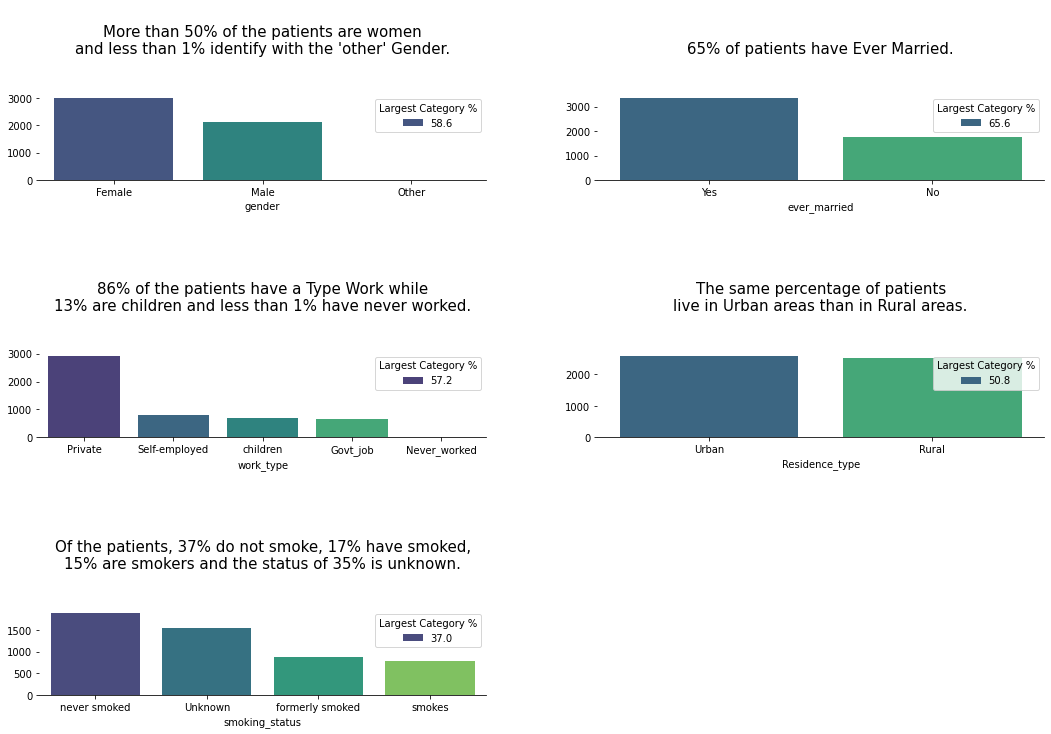

In [0]:
# List of categorical features (excluding the target 'stroke')
features_cat = [column for column in df.columns if column != 'stroke' and 'String' in str(df.schema[column].dataType)]

# Plot description
description = [
    "\nMore than 50% of the patients are women\nand less than 1% identify with the 'other' Gender.\n\n",
    "\n65% of patients have Ever Married.\n\n",
    "\n86% of the patients have a Type Work while\n13% are children and less than 1% have never worked.\n\n",
    "\nThe same percentage of patients\nlive in Urban areas than in Rural areas.\n\n",
    "\nOf the patients, 37% do not smoke, 17% have smoked,\n15% are smokers and the status of 35% is unknown.\n\n"
]

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = df.toPandas()

# Grid Plot
fig = plt.figure(figsize=(18, 30))
gs = gridspec.GridSpec(7, 2)
gs.update(wspace=0.25, hspace=2.0)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_cat):
    ax = plt.subplot(gs[i])
    sns.countplot(pandas_df[j], palette='viridis', order=pandas_df[j].value_counts().index)
    ax.set_title(description[i], fontsize=15)
    ax.legend([(x / len(pandas_df) * 100).round(1) for x in pandas_df[j].value_counts().values], title='Largest Category %')
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')

plt.show()


**Observations:**

🔎 Features like "Hypertension" and "Heart Disease" are highly unbalanced.

🔎 Features like "Gender" and "Work Type" have categories with less than 0% of the data.

🔎 "Smoking Status" of 35% of patients is unknown (category "Unknown").

### 4.2.2. Analysis of Numerical Features.

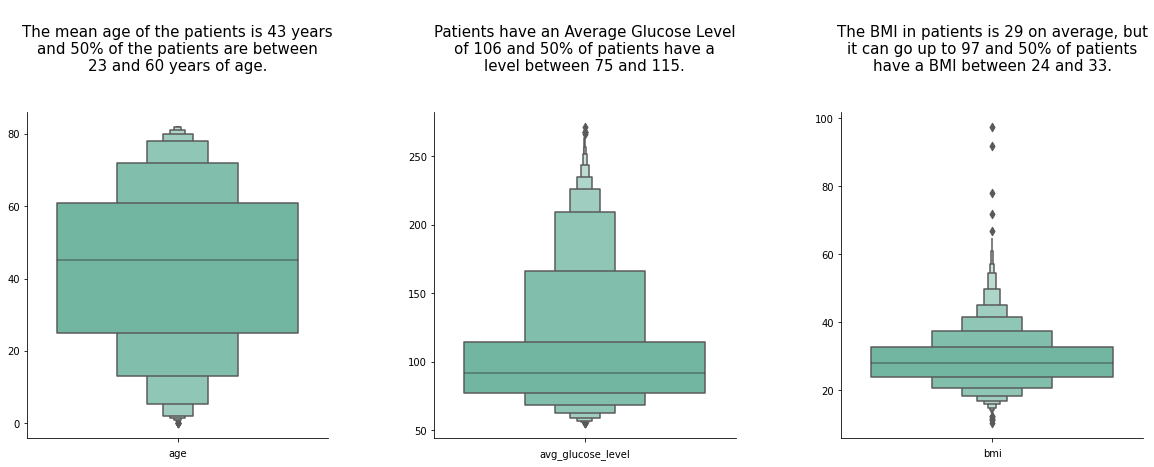

In [0]:
pandas_df = df.toPandas()

# Numerical Features.
features_num = pandas_df.select_dtypes(include='float64').columns

# Plot Description.
description = [str(f'\nThe mean age of the patients is 43 years\nand 50% of the patients are between\n23 and 60 years of age.\n\n'),
               str(f'Patients have an Average Glucose Level\nof 106 and 50% of patients have a\nlevel between 75 and 115.\n\n'),
               str(f'The BMI in patients is 29 on average, but\nit can go up to 97 and 50% of patients\nhave a BMI between 24 and 33.\n\n')]

# Grid Plot.
fig = plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1,3)
gs.update(wspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_num.values):
    ax = plt.subplot(gs[i])
    sns.boxenplot(y=pandas_df[j], palette=palette)
    ax.set_title(description[i], fontsize=15)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
plt.show()

**Observations:**

🔎 The "age" Feature has a gaussian distribution.

🔎 The Features "avg_glucose_level" and "bmi" have a right-skewed distribution.

🔎 All the features have outliers but "bmi" is the one with the most marked ones.

🔎 The detected outliers must be considered so that they do not bias the classification model.

## 4.2. Multivariate Analysis

### 4.2.1. Features Matrix Correlation.

                                     age  hypertension  heart_disease  \
age                             1.000000      0.276398       0.263796   
hypertension                    0.276398      1.000000       0.108306   
heart_disease                   0.263796      0.108306       1.000000   
avg_glucose_level               0.238171      0.174474       0.161857   
bmi                             0.324079      0.158050       0.036665   
ever_married_yes                0.679125      0.164243       0.114644   
Residence_type_urban            0.014180     -0.007913       0.003092   
gender_male                     0.027924     -0.021143      -0.085617   
work_type_Never_worked          0.116534     -0.005413       0.000027   
work_type_Private               0.327989      0.115442       0.086760   
work_type_Self-employed        -0.634215     -0.129506      -0.091634   
work_type_children              0.130013      0.017685       0.001330   
smoking_status_formerly_smoked  0.119307      0.065

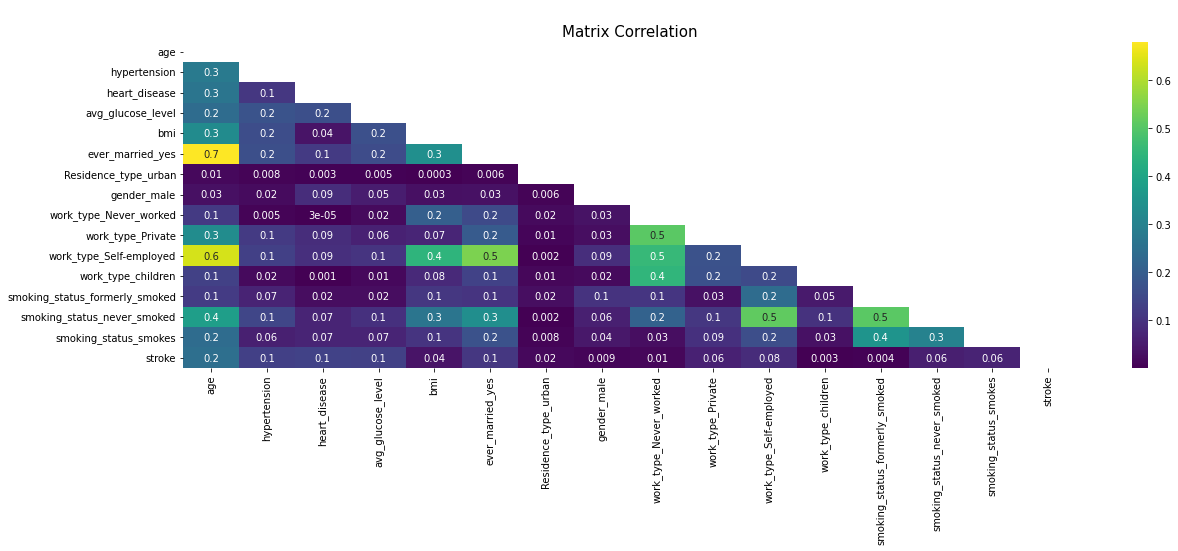

In [0]:
# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=df_encoded.columns, outputCol="features")
df_assembled = vector_assembler.transform(df_encoded).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, "features").head()

# Extract the correlation matrix as a NumPy array
corr_array = correlation_matrix[0].toArray()

# Convert the correlation matrix to a Pandas DataFrame
df_corr = pd.DataFrame(corr_array, columns=df_encoded.columns, index=df_encoded.columns)

# Display the Pandas DataFrame (optional)
print(df_corr)

# using matplotlib and seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20, 6))
sns.heatmap(df_corr.abs(), annot=True, fmt=".1g", cmap="viridis", cbar=True, mask=np.triu(df_corr))
plt.title("\nMatrix Correlation", fontsize=15)
plt.show()

**Observations:**ag

🔎 There is only one high correlation (greater than 0.7) in the crossing of the features "age" with "ever_married_yes".

🔎 There are 10 crosses between the features with moderate correlations (in a range of 0.3 to 0.6).

🔎 The rest of the crosses are of low correlations (less than 0.3).

### 4.2.2. Higher and Less Correlation with the Target.

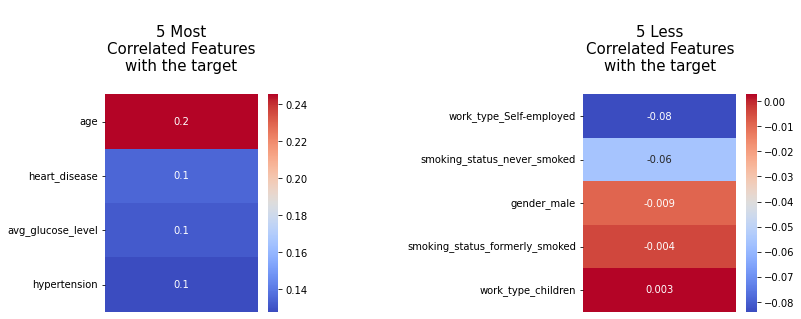

In [0]:
# DF with the features with the highest correlation and the target is removed.
corr_higher = pd.DataFrame(df_corr['stroke'].sort_values(ascending=False)).head()
corr_higher = corr_higher.drop('stroke', axis=0)

# DF with the features with less correlation.
corr_less = pd.DataFrame(df_corr['stroke'].sort_values()).head()

# List of DFs of Correlations
corr_ls = [corr_higher, corr_less]

# Plot Description.
description = [str(f'\n5 Most\nCorrelated Features\nwith the target\n'), str(f'5 Less\nCorrelated Features\nwith the target\n')]

# Define color palette
palette_matrix = sns.color_palette("coolwarm", as_cmap=True)

# Grid Plot.
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1.5, hspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(corr_ls):
    ax = plt.subplot(gs[i])
    sns.heatmap(corr_ls[i], annot=True, fmt='.1g', cmap=palette_matrix, cbar=True)
    ax.set_title(description[i], fontsize=15)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
plt.show()

**Observations:**

🔎 "age" is the feature that has the highest correlation with the target ("Stroke") with a low correlation of 0.2.

🔎 "work_type_Self-employed" is the feature that has the least correlation with the target ("Stroke") with -0.08 of correlation.

# 5. Model.

## 5.1. Preprocessing for Model.

### 5.1.1. Data Standardize

In [0]:
# Combine the features into a single vector column
assembler = VectorAssembler(inputCols=["age", "avg_glucose_level", "bmi"], outputCol="features")
df_assembled = assembler.transform(df_encoded)

# Create a StandardScaler object
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit and transform the DataFrame
scaler_model = scaler.fit(df_assembled)
scaled_df = scaler_model.transform(df_assembled)

# UDF to convert vectors to lists
vector_to_list_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Apply the UDF to the specified columns
scaled_df = (
    scaled_df
    .withColumn("scaled_features", vector_to_list_udf("scaled_features"))
)

scaled_df = (
    scaled_df
    .withColumn("age", col("scaled_features")[0])
    .withColumn("avg_glucose_level", col("scaled_features")[1])
    .withColumn("bmi", col("scaled_features")[2])
    .drop("features", "scaled_features")
)

# Display the result
display(HTML(scaled_df.toPandas().head(5).to_html(escape=False)))

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_yes,Residence_type_urban,gender_male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes,stroke
0,1.051331,0,1,2.706111,1.005444,1,1,0,1,0,0,0,0,0,1,1
1,0.785993,0,0,2.121351,-0.111442,1,0,1,0,1,0,0,1,0,0,1
2,1.626231,0,1,-0.005028,0.472975,1,0,0,1,0,0,0,1,0,0,1
3,0.255317,0,0,1.437217,0.719729,1,1,1,1,0,0,0,0,0,0,1
4,1.582008,1,0,1.501038,-0.630924,1,0,1,0,1,0,0,1,0,0,1


**Observations:**

🔎 The data is standardized and centers the selected features using a StandardScaler, because many ML techniques work under the assumption that the data is normally distributed.

🔎 It is decided to use the VectorAssembler and standard scalar transformers so that the model is not affected by the outliers.

###5.1.2. Undersampling the majority outcome

In [0]:
major_df = scaled_df.filter(scaled_df.stroke == 0)
minor_df = scaled_df.filter(scaled_df.stroke == 1)
# Undersample majority class
undersampled_major_df = major_df.sample(minor_df.count() / major_df.count(), seed=42)

# Combine undersampled majority class and minority class
balanced_df = minor_df.union(undersampled_major_df)

# Display the result
display(HTML(balanced_df.toPandas().head(5).to_html(escape=False)))

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_yes,Residence_type_urban,gender_male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes,stroke
0,1.051331,0,1,2.706111,1.005444,1,1,0,1,0,0,0,0,0,1,1
1,0.785993,0,0,2.121351,-0.111442,1,0,1,0,1,0,0,1,0,0,1
2,1.626231,0,1,-0.005028,0.472975,1,0,0,1,0,0,0,1,0,0,1
3,0.255317,0,0,1.437217,0.719729,1,1,1,1,0,0,0,0,0,0,1
4,1.582008,1,0,1.501038,-0.630924,1,0,1,0,1,0,0,1,0,0,1


**Observations:**

🔎 When dealing with datasets where one group is much smaller, using basic accuracy as a measure can be misleading. If a model consistently predicts the majority group, it may seem accurate but isn't effectively handling the smaller groups. So, in such cases, we need more thoughtful ways to evaluate the model's performance.

In [0]:
#Number of rows after balancing the data
balanced_df.count()

Out[64]: 522

##5.2. Applying models : Logistic Regression

In [0]:
feature_cols = balanced_df.drop("stroke").columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")

# Create a Logistic Regression model
logistic_regression = LogisticRegression(featuresCol="features_vector", labelCol="stroke", maxIter=10, regParam=0.01)

# Create a pipeline to chain the VectorAssembler and Logistic Regression stages
pipeline = Pipeline(stages=[vector_assembler, logistic_regression])

# Fit the pipeline to the data
model = pipeline.fit(balanced_df)

# Transform the data using the trained model
result = model.transform(balanced_df)

# Display the result
display(HTML(result.select("stroke", "features_vector", "rawPrediction", "probability", "prediction").toPandas().head(5).to_html(escape=False)))

,stroke,features_vector,rawPrediction,probability,prediction
0,1,"(1.0513313991807545, 0.0, 1.0, 2.706110616938918, 1.005444433901707, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[-1.9345720080641584, 1.9345720080641584]","[0.1262453909863, 0.8737546090137001]",1.0
1,1,"(0.7859931540178339, 0.0, 0.0, 2.1213509400949206, -0.11144213124043303, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[0.16373414742454728, -0.16373414742454728]","[0.5408423328634023, 0.45915766713659767]",0.0
2,1,"(1.6262309303670828, 0.0, 1.0, -0.005027809274735759, 0.47297525749673325, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[-2.012981752277397, 2.012981752277397]","[0.11784664499091736, 0.8821533550090827]",1.0
3,1,"(0.2553166636919924, 0.0, 0.0, 1.437217451098431, 0.7197292660746477, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.720677772807518, -0.720677772807518]","[0.6727562497965974, 0.3272437502034026]",0.0
4,1,"(1.5820078895065959, 1.0, 0.0, 1.5010375215696985, -0.6309242545623586, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[-1.6933176883264336, 1.6933176883264336]","[0.15534002994254023, 0.8446599700574597]",1.0


##5.2.1. Performance metrics

**Observations:**

🔎 As we are dealing with a classification problem, the evaluation metrics we concentrate are on accuracy, precision, recall, f1 score.

###5.2.1a. Performance metrics for the testing data

In [0]:
balanced_df = balanced_df.withColumn("stroke", df["stroke"].cast(DoubleType()))
# Split the data into training and testing sets
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Transform the testing data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))


Area under ROC = 0.84


In [0]:
# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_1 = [list(row) for row in confusion_matrix.toArray()]
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Accuracy = 75.86%
Confusion Matrix:
DenseMatrix([[38., 17.],
             [11., 50.]])


###5.2.1b. Performance metrics for the training data

In [0]:
# Transform the training data
predictions = model.transform(train_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_2 = [list(row) for row in confusion_matrix.toArray()]

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Area under ROC = 0.86
Accuracy = 78.82%
Confusion Matrix:
DenseMatrix([[171.,  47.],
             [ 39., 149.]])


##5.2.2. Confusion Matrix

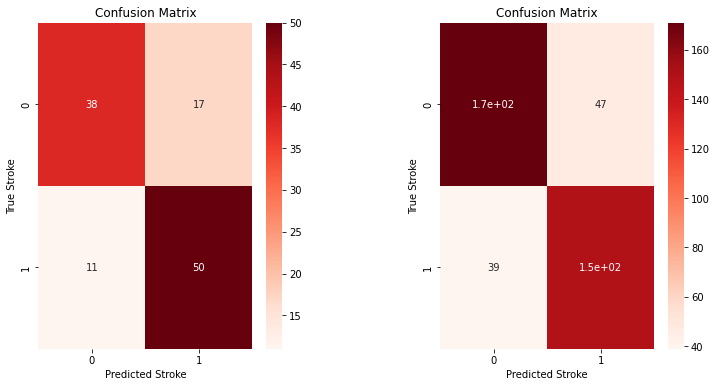

In [0]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# loop over the subplots and create the confusion matrix plots
for i, ax in enumerate(axs):
    # get the corresponding confusion matrix data
    if i == 0:
        confusion_matrix_data = confusion_matrix_1
    else:
        confusion_matrix_data = confusion_matrix_2
    
    # create the confusion matrix plot
    confusion_matrix_plot = sns.heatmap(confusion_matrix_data, annot=True, cmap='Reds', ax=ax)
    confusion_matrix_plot.set_xlabel('Predicted Stroke')
    confusion_matrix_plot.set_ylabel('True Stroke')
    confusion_matrix_plot.set_title('Confusion Matrix')
    
# adjust the space between the subplots and show the figure
plt.subplots_adjust(wspace=0.5)
plt.show()


##5.2.3. Logistic Regression with tuning and validation

In [0]:
# split the data into training and testing sets
(train, test) = balanced_df.randomSplit([0.6, 0.4], seed=20)

# create RFormula for the logistic regression model
formula = RFormula(formula="stroke ~ . - stroke", featuresCol="features", labelCol="label")

# create a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# create a pipeline that includes the RFormula and logistic regression model
pipeline = Pipeline(stages=[formula, lr])

# create a cross-validator with 5 folds and the pipeline
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .addGrid(lr.maxIter, [5,10]) \
    .build()
# create a cross-validator with 10 folds and the pipeline
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=10)

# fit the model on the training data
model = cv.fit(train)

# use the trained model to make predictions on the testing data
predictions = model.transform(test)

# calculate performance metrics (AUC and accuracy)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_lr = evaluator.evaluate(predictions)
accuracy_lr = predictions.filter(predictions.stroke == predictions.prediction).count() / float(predictions.count())

# print the performance metrics
print("Area under ROC = %g" % auc_lr)
print("Accuracy = %g" % accuracy_lr)

Area under ROC = 0.840447
Accuracy = 0.76699


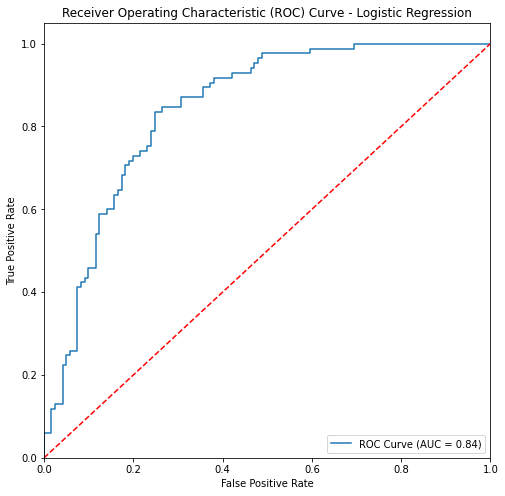

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get the probability column from the predictions
probs = predictions.select("label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))

# Convert to NumPy array for compatibility with scikit-learn
probs = np.array(probs.collect())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(probs[:, 1], probs[:, 0])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % auc_lr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


##5.3. Applying models : Decision Tree Classifier

In [0]:
feature_cols = balanced_df.drop("stroke").columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")

# Create Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(labelCol="stroke", featuresCol="features_vector", maxDepth=5)

# Create a pipeline for Decision Tree
dt_pipeline = Pipeline(stages=[vector_assembler, dt_classifier])

# Train the model
dt_model = dt_pipeline.fit(balanced_df)

# Make predictions on the test data
dt_results = dt_model.transform(balanced_df)

# Display the result
display(HTML(dt_results.select("stroke", "features_vector", "rawPrediction", "probability", "prediction").toPandas().head(5).to_html(escape=False)))

,stroke,features_vector,rawPrediction,probability,prediction
0,1.0,"(1.0513313991807545, 0.0, 1.0, 2.706110616938918, 1.005444433901707, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[14.0, 84.0]","[0.14285714285714285, 0.8571428571428571]",1.0
1,1.0,"(0.7859931540178339, 0.0, 0.0, 2.1213509400949206, -0.11144213124043303, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[1.0, 23.0]","[0.041666666666666664, 0.9583333333333334]",1.0
2,1.0,"(1.6262309303670828, 0.0, 1.0, -0.005027809274735759, 0.47297525749673325, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[14.0, 84.0]","[0.14285714285714285, 0.8571428571428571]",1.0
3,1.0,"(0.2553166636919924, 0.0, 0.0, 1.437217451098431, 0.7197292660746477, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[21.0, 2.0]","[0.9130434782608695, 0.08695652173913043]",0.0
4,1.0,"(1.5820078895065959, 1.0, 0.0, 1.5010375215696985, -0.6309242545623586, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[14.0, 84.0]","[0.14285714285714285, 0.8571428571428571]",1.0


###5.3.1a. Performance metrics for the testing data

In [0]:
#balanced_df = balanced_df.withColumn("stroke", df["stroke"].cast(DoubleType()))
# Split the data into training and testing sets
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the pipeline to the training data
model = dt_pipeline.fit(train_data)

# Transform the testing data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_1 = [list(row) for row in confusion_matrix.toArray()]
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Area under ROC = 0.74
Accuracy = 70.69%
Confusion Matrix:
DenseMatrix([[45., 10.],
             [24., 37.]])


###5.3.1b. Performance metrics for the training data

In [0]:
# Transform the training data
predictions = model.transform(train_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_2 = [list(row) for row in confusion_matrix.toArray()]

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Area under ROC = 0.84
Accuracy = 82.51%
Confusion Matrix:
DenseMatrix([[189.,  29.],
             [ 42., 146.]])


##5.3.2. Confusion Matrix

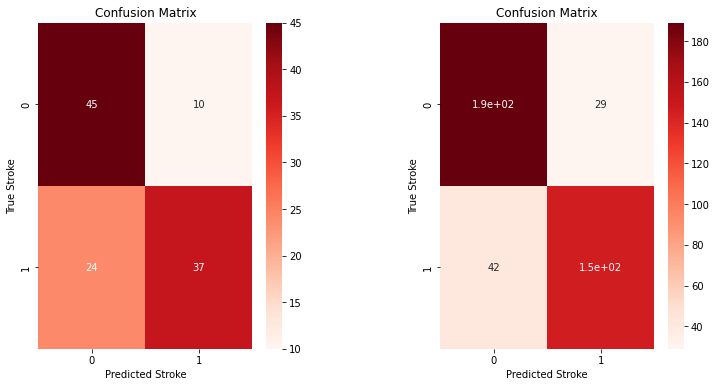

In [0]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# loop over the subplots and create the confusion matrix plots
for i, ax in enumerate(axs):
    # get the corresponding confusion matrix data
    if i == 0:
        confusion_matrix_data = confusion_matrix_1
    else:
        confusion_matrix_data = confusion_matrix_2
    
    # create the confusion matrix plot
    confusion_matrix_plot = sns.heatmap(confusion_matrix_data, annot=True, cmap='Reds', ax=ax)
    confusion_matrix_plot.set_xlabel('Predicted Stroke')
    confusion_matrix_plot.set_ylabel('True Stroke')
    confusion_matrix_plot.set_title('Confusion Matrix')
    
# adjust the space between the subplots and show the figure
plt.subplots_adjust(wspace=0.5)
plt.show()


##5.3.3. Decision Tree Classifier with tuning and validation

In [0]:
# split the data into training and testing sets
(train, test) = balanced_df.randomSplit([0.6, 0.4], seed=20)

# create RFormula for the logistic regression model
formula = RFormula(formula="stroke ~ . - stroke", featuresCol="features", labelCol="label")

# Create Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)

# create a pipeline that includes the RFormula and logistic regression model
pipeline = Pipeline(stages=[formula, dt_classifier])

# Create a cross-validator with 10 folds and the pipeline
paramGrid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10]) \
    .build()

# Create a cross-validator with 10 folds and the pipeline
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=10)

# Fit the model on the training data
model = cv.fit(train)

# Use the trained model to make predictions on the testing data
predictions = model.transform(test)

# Calculate performance metrics (AUC and accuracy)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_dtc = evaluator.evaluate(predictions)
accuracy_dtc = predictions.filter(predictions.stroke == predictions.prediction).count() / float(predictions.count())

# Print the performance metrics
print("Area under ROC = %g" % auc_dtc)
print("Accuracy = %g" % accuracy_dtc)

Area under ROC = 0.770151
Accuracy = 0.728155


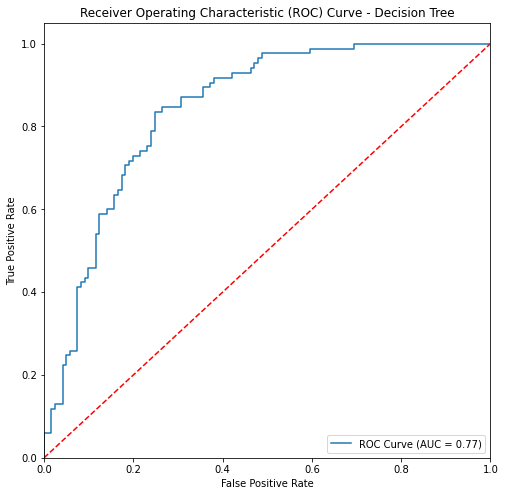

In [0]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % auc_dtc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

##5.4. Applying models : Random Forest Classifier

In [0]:
feature_cols = balanced_df.drop("stroke").columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")

# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(labelCol="stroke", featuresCol="features_vector", maxDepth=5, numTrees=10)

# Create a pipeline for Random Forest
rf_pipeline = Pipeline(stages=[vector_assembler, rf_classifier])

# Train the model
rf_model = rf_pipeline.fit(balanced_df)

# Make predictions on the test data
rf_results = rf_model.transform(balanced_df)

# Display the result
display(HTML(rf_results.select("stroke", "features_vector", "rawPrediction", "probability", "prediction").toPandas().head(5).to_html(escape=False)))

,stroke,features_vector,rawPrediction,probability,prediction
0,1.0,"(1.0513313991807545, 0.0, 1.0, 2.706110616938918, 1.005444433901707, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[1.8095154436077017, 8.190484556392297]","[0.1809515443607702, 0.8190484556392299]",1.0
1,1.0,"(0.7859931540178339, 0.0, 0.0, 2.1213509400949206, -0.11144213124043303, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[3.091446034430171, 6.908553965569828]","[0.3091446034430171, 0.6908553965569828]",1.0
2,1.0,"(1.6262309303670828, 0.0, 1.0, -0.005027809274735759, 0.47297525749673325, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[1.9929323154861696, 8.00706768451383]","[0.19929323154861694, 0.800706768451383]",1.0
3,1.0,"(0.2553166636919924, 0.0, 0.0, 1.437217451098431, 0.7197292660746477, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[7.201667264717906, 2.798332735282095]","[0.7201667264717906, 0.2798332735282095]",0.0
4,1.0,"(1.5820078895065959, 1.0, 0.0, 1.5010375215696985, -0.6309242545623586, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[2.8341547785773242, 7.165845221422675]","[0.2834154778577324, 0.7165845221422675]",1.0


###5.4.1a. Performance metrics for the testing data

In [0]:
# Split the data into training and testing sets
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the pipeline to the training data
model = dt_pipeline.fit(train_data)

# Transform the testing data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_1 = [list(row) for row in confusion_matrix.toArray()]
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Area under ROC = 0.74
Accuracy = 70.69%
Confusion Matrix:
DenseMatrix([[45., 10.],
             [24., 37.]])


###5.4.1b. Performance metrics for the training data

In [0]:
# Transform the training data
predictions = model.transform(train_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Display the area under ROC
print("Area under ROC = {:.2f}".format(area_under_roc))

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display accuracy
print("Accuracy = {:.2%}".format(accuracy))

# Compute confusion matrix
prediction_and_labels = predictions.select("prediction", "stroke").rdd
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_2 = [list(row) for row in confusion_matrix.toArray()]

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Area under ROC = 0.84
Accuracy = 82.51%
Confusion Matrix:
DenseMatrix([[189.,  29.],
             [ 42., 146.]])


##5.4.2. Confusion Matrix

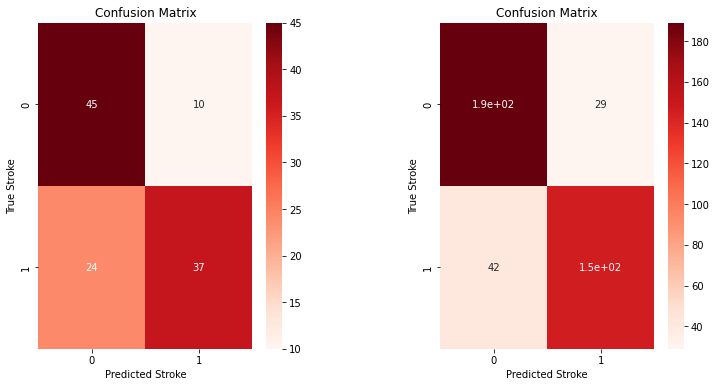

In [0]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# loop over the subplots and create the confusion matrix plots
for i, ax in enumerate(axs):
    # get the corresponding confusion matrix data
    if i == 0:
        confusion_matrix_data = confusion_matrix_1
    else:
        confusion_matrix_data = confusion_matrix_2
    
    # create the confusion matrix plot
    confusion_matrix_plot = sns.heatmap(confusion_matrix_data, annot=True, cmap='Reds', ax=ax)
    confusion_matrix_plot.set_xlabel('Predicted Stroke')
    confusion_matrix_plot.set_ylabel('True Stroke')
    confusion_matrix_plot.set_title('Confusion Matrix')
    
# adjust the space between the subplots and show the figure
plt.subplots_adjust(wspace=0.5)
plt.show()


##5.4.3. Random Forest Classifier with tuning and validation

In [0]:
# split the data into training and testing sets
(train, test) = balanced_df.randomSplit([0.6, 0.4], seed=20)

# create RFormula for the logistic regression model
formula = RFormula(formula="stroke ~ . - stroke", featuresCol="features", labelCol="label")

# Create a Random Forest model
rf_classifier = RandomForestClassifier(labelCol="stroke", featuresCol="features", maxDepth=5, numTrees=10)

# Create a pipeline that includes the RFormula and Random Forest model
pipeline = Pipeline(stages=[formula, rf_classifier])

# Create a parameter grid for the Random Forest model
paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.maxDepth, [5, 10]) \
    .addGrid(rf_classifier.numTrees, [10, 20]) \
    .build()

# Create a cross-validator with 10 folds and the pipeline
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=10)

# Fit the model on the training data
model = cv.fit(train)

# Use the trained model to make predictions on the testing data
predictions = model.transform(test)

# Calculate performance metrics (AUC and accuracy)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="stroke", metricName="areaUnderROC")
auc_rf = evaluator.evaluate(predictions)
accuracy_rf = predictions.filter(predictions.stroke == predictions.prediction).count() / float(predictions.count())

# Print the performance metrics
print("Area under ROC = %g" % auc_rf)
print("Accuracy = %g" % accuracy_rf)

Area under ROC = 0.842392
Accuracy = 0.737864


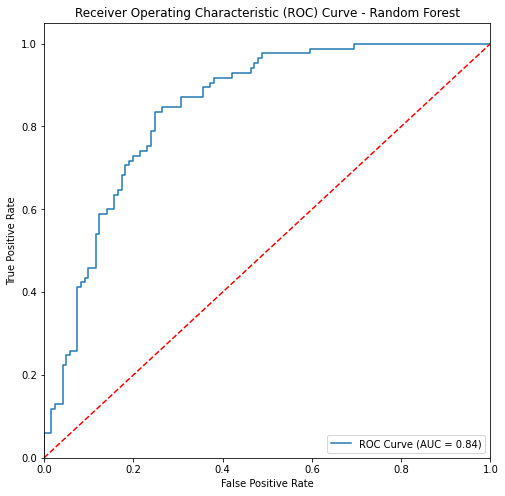

In [0]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % auc_rf)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

##6. Summary

🔎 This model can predict the chance of getting a heart stroke and hence can be utilised for saving the lives by predicting.

🔎 We shall try the performance of other models in the future so that the accuracy and recall can be analysed and enhanced.

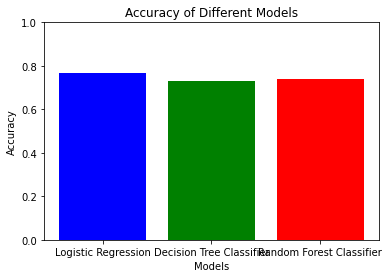

In [0]:
# Plotting
model_names = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier']
accuracy_values = [accuracy_lr, accuracy_dtc, accuracy_rf]

plt.bar(model_names, accuracy_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for accuracy values
plt.show()